In [ ]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.integrate import quad
from scipy import integrate as intg
import sympy as sp
from scipy import stats
from scipy.interpolate import UnivariateSpline
import pandas as pd
from scipy.stats import linregress
from scipy.stats import norm
import os
import seaborn as sns
from matplotlib import pyplot as plt, patches
#!pip statistics
import statistics

!pip install git+https://github.com/mfouesneau/ezpadova
import ezpadova

drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive', force_remount=True)

  Cloning https://github.com/mfouesneau/ezpadova to /tmp/pip-req-build-9safer6y
  Running command git clone --filter=blob:none --quiet https://github.com/mfouesneau/ezpadova /tmp/pip-req-build-9safer6y
  Resolved https://github.com/mfouesneau/ezpadova to commit f39625883e22a619b180c73b290a46a2a137f05e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Mounted at /content/drive


In [ ]:
#folder = os.path.join('/content/drive/MyDrive/Chris and Punya Project')

folder = os.path.join('/content/drive/MyDrive/galactic project/Chris and Punya Project')



In [ ]:
r = ezpadova.get_isochrones(photsys_file='gaiaEDR3', logage=(6, 10, 0.2), MH=(-2, 1, 0.4))

Querying http://stev.oapd.inaf.it/cgi-bin/cmd...
Retrieving data...


# Reading in the Data


In [ ]:
#Open FITS file:
#hdu = fits.open('/content/drive/MyDrive/Chris and Punya Project/table_2_catwise.fits')
hdu = fits.open('/content/drive/MyDrive/galactic project/Chris and Punya Project/table_2_catwise.fits')

#An HDU (Header Data Unit) consist of a header and (typically) a data array or table.

#Check our HDU information, slices and cube:
print(hdu.info())
header = hdu[0].header

data = hdu[1].data
print(data.columns)


print(list(header.keys()))


Filename: /content/drive/MyDrive/galactic project/Chris and Punya Project/table_2_catwise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     55   17558141R x 23C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, L]   
None
ColDefs(
    name = 'source_id'; format = 'K'; null = 999999
    name = 'l'; format = 'D'
    name = 'b'; format = 'D'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'parallax'; format = 'D'
    name = 'parallax_error'; format = 'D'
    name = 'pmra'; format = 'D'
    name = 'pmra_error'; format = 'D'
    name = 'pmdec'; format = 'D'
    name = 'pmdec_error'; format = 'D'
    name = 'ruwe'; format = 'D'
    name = 'radial_velocity'; format = 'D'
    name = 'radial_velocity_error'; format = 'D'
    name = 'phot_g_mean_mag'; format = 'D'
    name = 'phot_bp_mean_mag'; format = 'D'
    name = 'phot_rp_mean_mag'; format = 'D'

In [ ]:
cols = ["source_id", "ra", "dec", "parallax", "phot_g_mean_mag"]
df = pd.DataFrame({c: data[c] for c in cols})
df.head()


,source_id,ra,dec,parallax,phot_g_mean_mag
0,15741055975040,45.136038,0.335043,1.439792,10.254021
1,25980257976960,44.850926,0.398492,2.021930,11.724060
2,66627828480768,45.305053,0.736093,0.534038,10.508830
3,82467667849472,44.866246,0.561503,2.209985,10.651456
4,101193725229056,44.569524,0.689953,0.528788,14.332739


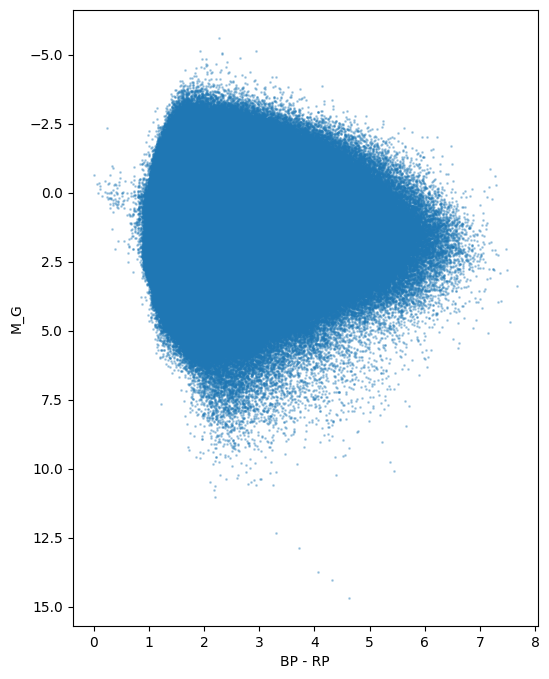

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bp = data["phot_bp_mean_mag"]
rp = data["phot_rp_mean_mag"]
g  = data["phot_g_mean_mag"]
par = data["parallax"]

dist = 1000 / par
abs_g = g - 5 * np.log10(dist) + 5

plt.figure(figsize=(6,8))
plt.scatter(bp - rp, abs_g, s=1, alpha=0.3)
plt.gca().invert_yaxis()
plt.xlabel("BP - RP")
plt.ylabel("M_G")
plt.show()




```
# This is formatted as code
```

# Isochrones


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
